In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

#import sklearn.metrics
from sklearn.metrics import mean_squared_error, max_error
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector

from collections import Counter



SEED = 15
np.random.seed(SEED)


We start by loading the previously created dataframe with the answers to the questions we asked gpt. We also read the 20 questions, which are stored in `questions` below.

In [2]:
romance_with_binary = pd.read_csv('./Data/Preprocessed/romances.with.binary.tsv', delimiter='\t')
romance_with_binary.head(3)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000


In [3]:
print(romance_with_binary['genres'])

0              ['Drama', 'Comedy', 'Romance', 'Ensemble']
1                          ['Comedy', 'Romance', 'Indie']
2          ['World Cinema', 'Comedy', 'Romance', 'Indie']
3                                   ['Comedy', 'Romance']
4                                   ['Comedy', 'Romance']
                              ...                        
5877    ['Comedy', 'Romance', 'LGBT', 'World Cinema', ...
5878    ['Romance', 'Biopic', 'History', 'LGBT', 'Worl...
5879                       ['Drama', 'Comedy', 'Romance']
5880    ['Comedy', 'Romance', 'Indie', 'Religious', 'F...
5881    ['Drama', 'Action', 'Romance', 'Science Fiction']
Name: genres, Length: 5882, dtype: object


# one-hot encoding of Genres

In [4]:
import ast

# Convert the string representations to lists using ast.literal_eval
romance_with_binary['genres'] = romance_with_binary['genres'].apply(ast.literal_eval)

# Get unique genres
unique_genres = set(genre for genres_list in romance_with_binary['genres'] for genre in genres_list)

# Convert the set to a list if needed
genres_list = sorted(list(unique_genres))
print(len(genres_list), genres_list)

one_hot_genres = romance_with_binary['genres'].str.join('|').str.get_dummies()
romance_with_binary_genre = pd.concat([romance_with_binary, one_hot_genres], axis=1)
romance_with_binary_genre.head(3)

100 ['Action', 'Adaptation', 'Adventure', 'Alien', 'Americana', 'Animal', 'Animation', 'Anime', 'Anti War', 'Art', 'Avant Garde', 'B-Movie', 'Beach', 'Biopic', 'Black Comedy', 'Black-and-white', 'Blaxploitation', 'Bollywood', 'Cars', 'Children', 'Christmas', 'Comedy', 'Coming Of Age', 'Costume', 'Crime', 'Culture And Society', 'Dance', 'Detective', 'Disaster', 'Documentary', 'Drama', 'Drugs', 'Dystopia', 'Educational', 'Ensemble', 'Epic', 'Erotic', 'Escape', 'Family', 'Fantasy', 'Feminist', 'Fiction', 'Film', 'Film A Clef', 'Gangster', 'Gay', 'Gothic', 'Heist', 'History', 'Horror', 'Indie', 'LGBT', 'Law', 'Marriage Drama', 'Martial Arts', 'Medical', 'Melodrama', 'Mockumentary', 'Monster', 'Movie', 'Music', 'Musical', 'Mystery', 'Nature', 'New Hollywood', 'Noir', 'Parody', 'Period', 'Political', 'Politics', 'Pornography', 'Prison', 'Propaganda', 'Psychological Thriller', 'Religious', 'Road', 'Romance', 'Satire', 'Science Fiction', 'Sexploitation', 'Silent', 'Slapstick', 'Slasher', 'Soci

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,...,Supernatural,Suspense,Teen,Television,Thriller,Tragicomedy,War,Western,World Cinema,Zombie
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"[Drama, Comedy, Romance, Ensemble]",tt0119548,...,0,0,0,0,0,0,0,0,0,0
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"[Comedy, Romance, Indie]",tt0892904,...,0,0,0,0,0,0,0,0,0,0
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"[World Cinema, Comedy, Romance, Indie]",tt0178022,...,0,0,0,0,0,0,0,0,1,0


In [5]:
f = open('Data/trope_questions.txt', 'r')

line = f.readline()
questions = []

while len(line)!=0:
    questions.append(line.strip())
    line = f.readline()
    
questions = questions[1:-1]

# A) Preprocessing of questions (not updated)

In [6]:
gpt_answers = romance_with_binary[['movie_id', 'binary_answers']].copy()
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))
#gpt_answers.head(3)

In [7]:
bits = {'0', '1', '2'}
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: ''.join(c for c in b if c in bits))
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))

In [8]:
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: b if len(b)==20 else '2'*20)
gpt_answers.drop(columns=['response_length'], inplace=True)
gpt_answers.head(5)

,movie_id,binary_answers
0,6631279,01001000000001111000
1,21926710,00000001000001000100
2,26067101,01000000001000001000
3,12053509,01000000000111011000
4,7028314,00010011010001001000


In [9]:
for q_nb, question in enumerate(questions):
    gpt_answers[f'q_{q_nb}'] = gpt_answers['binary_answers'].apply(lambda b: int(b[q_nb]))
    
gpt_answers.head(5)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


And let's plot how many answers to the questions were negative, positive and unknown for each question.

In [10]:
def plot(df):
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        sbplt = ax[i%4, math.floor(i/4)]
        sbplt.hist(df[f'q_{i}'])
        sbplt.set_title(f'Question {i}')

    fig.tight_layout()
    fig.suptitle('Histogram of answers (0, 1, and 2) for each question', y=1.05, fontsize=20)
    plt.show()

#plot(gpt_answers)

In [11]:
def plot_pie_charts(df):
    fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (12,10))

    for r in range(4):
        for c in range(5):
            ax[r,c].pie(df[f'q_{r*5+c}'].value_counts(),
                        labels = df[f'q_{r*5+c}'].dropna().unique(),
                        autopct=lambda p: '{:.1f}%'.format(p),
                        startangle=90, shadow=False)
            ax[r,c].set_title(f'Question {r*5+c}')
    
    fig.suptitle('Pie charts of percentage of answers (0, 1, and 2) for each question', y=1.01, fontsize=15)
    fig.tight_layout()
            
#plot_pie_charts(gpt_answers)

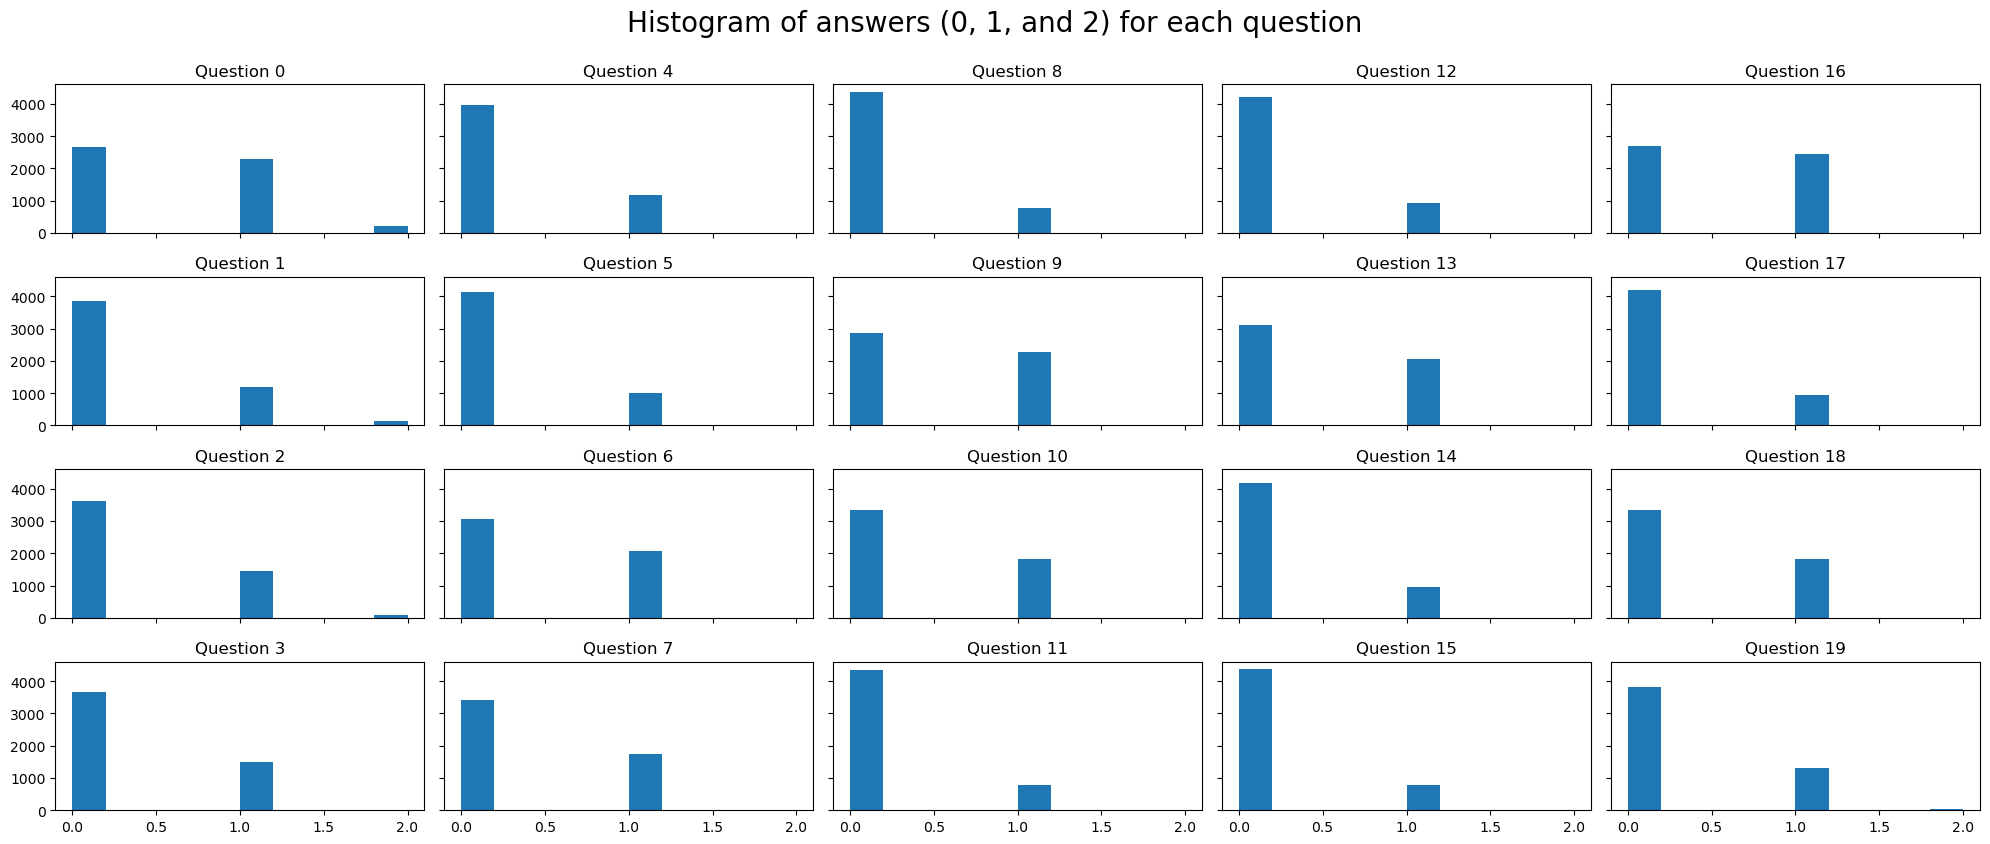

In [12]:
relevant_answers = gpt_answers[gpt_answers['binary_answers']!='2'*20].copy()
relevant_answers2 = relevant_answers[relevant_answers['binary_answers'].str.contains('1')].copy()
#plot_pie_charts(relevant_answers2)
plot(relevant_answers2)

In [13]:
col_to_keep = ['movie_id', 'movie_release', 'binary_answers']
for i in range(len(questions)):
    col_to_keep.append(f'q_{i}')
    
#right merge because we only care about the relevant answers
gpt_year = romance_with_binary_genre.merge(relevant_answers2, on=['movie_id', 'binary_answers'], how='right')[col_to_keep]
gpt_year.replace(2, np.NaN, inplace=True)

gpt_year.columns

Index(['movie_id', 'movie_release', 'binary_answers', 'q_0', 'q_1', 'q_2',
       'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12',
       'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 'q_19'],
      dtype='object')

We now have `relevant_answers` which consists of all movies we can analyze.

# B) Analysis of ratings

In [14]:
trimmed = relevant_answers2.drop(['binary_answers'], axis = 1)
trimmed = trimmed.replace(2, np.NaN)
df = trimmed.merge(romance_with_binary_genre, on = 'movie_id', how = 'left')
display(df)

df.columns

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,Supernatural,Suspense,Teen,Television,Thriller,Tragicomedy,War,Western,World Cinema,Zombie
0,6631279,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,21926710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,26067101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,12053509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,7028314,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,4037444,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
5255,1191380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0
5256,54540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5257,1673588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Index(['movie_id', 'q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7',
       'q_8',
       ...
       'Supernatural', 'Suspense', 'Teen', 'Television', 'Thriller',
       'Tragicomedy', 'War', 'Western', 'World Cinema', 'Zombie'],
      dtype='object', length=133)

In [15]:
df['genres'].isna().sum() # 0

count = []

print(len(unique_genres), unique_genres)

for genre in unique_genres:
    count.append(df[genre].sum())

print(len(count), count)

100 {'New Hollywood', 'Parody', 'Feminist', 'Political', 'Biopic', 'Romance', 'Family', 'Politics', 'Propaganda', 'Movie', 'Music', 'Spaghetti', 'Black Comedy', 'Teen', 'Dance', 'Heist', 'Detective', 'Drama', 'Erotic', 'Animation', 'Christmas', 'Western', 'Action', 'Bollywood', 'Costume', 'Martial Arts', 'Prison', 'Slapstick', 'Law', 'Horror', 'Beach', 'Epic', 'Drugs', 'Sport', 'Superhero', 'Coming Of Age', 'Monster', 'War', 'Sexploitation', 'Disaster', 'Cars', 'Gay', 'Fiction', 'Silent', 'Slasher', 'Suspense', 'Culture And Society', 'Ensemble', 'Fantasy', 'Gothic', 'Musical', 'Road', 'Marriage Drama', 'Documentary', 'Science Fiction', 'Supernatural', 'Escape', 'Children', 'History', 'B-Movie', 'Medical', 'Pornography', 'Zombie', 'Adaptation', 'Anti War', 'Film A Clef', 'Mockumentary', 'Psychological Thriller', 'Film', 'Tragicomedy', 'Crime', 'Sports', 'Gangster', 'Art', 'Alien', 'Blaxploitation', 'Anime', 'Animal', 'Comedy', 'Melodrama', 'Indie', 'Dystopia', 'Spy', 'Social Issues', 'P

In [16]:
print(unique_genres)
print('df shape', np.shape(df))

genre_to_remove = []
for i, (genre, c) in enumerate(zip(unique_genres, count)):
    if c < 200: # 100 is arbitrary here
        df.drop(genre, axis = 1, inplace = True)
        genre_to_remove.append(genre)

print('Genre to remove:', len(genre_to_remove), genre_to_remove)

print('df shape', np.shape(df))


#print(unique_genres)

{'New Hollywood', 'Parody', 'Feminist', 'Political', 'Biopic', 'Romance', 'Family', 'Politics', 'Propaganda', 'Movie', 'Music', 'Spaghetti', 'Black Comedy', 'Teen', 'Dance', 'Heist', 'Detective', 'Drama', 'Erotic', 'Animation', 'Christmas', 'Western', 'Action', 'Bollywood', 'Costume', 'Martial Arts', 'Prison', 'Slapstick', 'Law', 'Horror', 'Beach', 'Epic', 'Drugs', 'Sport', 'Superhero', 'Coming Of Age', 'Monster', 'War', 'Sexploitation', 'Disaster', 'Cars', 'Gay', 'Fiction', 'Silent', 'Slasher', 'Suspense', 'Culture And Society', 'Ensemble', 'Fantasy', 'Gothic', 'Musical', 'Road', 'Marriage Drama', 'Documentary', 'Science Fiction', 'Supernatural', 'Escape', 'Children', 'History', 'B-Movie', 'Medical', 'Pornography', 'Zombie', 'Adaptation', 'Anti War', 'Film A Clef', 'Mockumentary', 'Psychological Thriller', 'Film', 'Tragicomedy', 'Crime', 'Sports', 'Gangster', 'Art', 'Alien', 'Blaxploitation', 'Anime', 'Animal', 'Comedy', 'Melodrama', 'Indie', 'Dystopia', 'Spy', 'Social Issues', 'Perio

In [17]:
display(df)
df.columns

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,Family,Fantasy,Gay,Indie,LGBT,Musical,Period,Romance,Thriller,World Cinema
0,6631279,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,21926710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,1,0,0
2,26067101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,1
3,12053509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,7028314,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,4037444,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,1,0,1
5255,1191380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,1,0,1,0,1,1,0,1
5256,54540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
5257,1673588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,1,0,0,0,1,0,0


Index(['movie_id', 'q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7',
       'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16',
       'q_17', 'q_18', 'q_19', 'index', 'movie_name', 'revenue', 'runtime',
       'languages', 'countries', 'movie_release', 'genres', 'imdb_id',
       'rating', 'nb_votes', 'binary_answers', 'Action', 'Adaptation',
       'Adventure', 'Black-and-white', 'Bollywood', 'Comedy', 'Coming Of Age',
       'Crime', 'Drama', 'Erotic', 'Family', 'Fantasy', 'Gay', 'Indie', 'LGBT',
       'Musical', 'Period', 'Romance', 'Thriller', 'World Cinema'],
      dtype='object')

In [18]:
print('df shape', np.shape(df))
print('nans in df')
print('revenue:', df['revenue'].isna().sum()) # 3403 
print('runtime:' ,df['runtime'].isna().sum()) # 199 
print('movie_release:', df['movie_release'].isna().sum()) # 0
print('rating:', df['rating'].isna().sum()) # 0
print('nb_votes:', df['nb_votes'].isna().sum()) # 0

print('q_0:', df['q_0'].isna().sum()) # 205
print('q_1:', df['q_1'].isna().sum()) # 136
print('q_2:', df['q_2'].isna().sum()) # 87
print('q_3:', df['q_3'].isna().sum()) # 8
print('q_4:', df['q_4'].isna().sum()) # 10
print('q_5:', df['q_5'].isna().sum()) # 27
print('q_6:', df['q_6'].isna().sum()) # 6
print('q_7:', df['q_7'].isna().sum()) # 7
print('q_8:', df['q_8'].isna().sum()) # 7
print('q_9:', df['q_9'].isna().sum()) # 13
print('q_10:', df['q_10'].isna().sum()) # 7
print('q_11:', df['q_11'].isna().sum()) # 9
print('q_12:', df['q_12'].isna().sum()) # 8
print('q_13:', df['q_13'].isna().sum()) # 8
print('q_16:', df['q_16'].isna().sum()) # 5
print('q_17:', df['q_17'].isna().sum()) # 6
print('q_18:', df['q_18'].isna().sum()) # 5
print('q_19:', df['q_19'].isna().sum()) # 37

df shape (5259, 53)
nans in df
revenue: 3403
runtime: 199
movie_release: 0
rating: 0
nb_votes: 0
q_0: 205
q_1: 136
q_2: 87
q_3: 8
q_4: 10
q_5: 27
q_6: 6
q_7: 7
q_8: 7
q_9: 13
q_10: 7
q_11: 9
q_12: 8
q_13: 8
q_16: 5
q_17: 6
q_18: 5
q_19: 37


In [19]:
# drop q_14 and q_15 because GPT is totaly lost
df = df.drop(['q_14', 'q_15'], axis = 1)

# drop the revenue because there are too many missing values
df = df.drop(['revenue'], axis = 1)

# drop genre romance because it is always 1
df = df.drop(['Romance'], axis = 1)

# drop useless columns
df = df.drop(['movie_id', 'index', 'movie_name', 'languages', 'countries', 'genres', 'imdb_id', 'binary_answers'], axis = 1)

# As we saw previously that the nb_votes is better in log
df['nb_votes'] = np.log(df['nb_votes'])

In [20]:
print('df shape', np.shape(df))

normalized_df=df.copy()
normalized_df.columns


df shape (5259, 41)


Index(['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9',
       'q_10', 'q_11', 'q_12', 'q_13', 'q_16', 'q_17', 'q_18', 'q_19',
       'runtime', 'movie_release', 'rating', 'nb_votes', 'Action',
       'Adaptation', 'Adventure', 'Black-and-white', 'Bollywood', 'Comedy',
       'Coming Of Age', 'Crime', 'Drama', 'Erotic', 'Family', 'Fantasy', 'Gay',
       'Indie', 'LGBT', 'Musical', 'Period', 'Thriller', 'World Cinema'],
      dtype='object')

juste une verification parce qu'il me semble que je dois faire un log pour le nb_votes

(array([  6.,  18.,  40.,  61., 116., 194., 355., 539., 584., 711., 650.,
        559., 436., 331., 264., 198., 126.,  51.,  15.,   5.]),
 array([ 1.60943791,  2.25899693,  2.90855594,  3.55811496,  4.20767397,
         4.85723299,  5.50679201,  6.15635102,  6.80591004,  7.45546905,
         8.10502807,  8.75458708,  9.4041461 , 10.05370511, 10.70326413,
        11.35282315, 12.00238216, 12.65194118, 13.30150019, 13.95105921,
        14.60061822]),
 <BarContainer object of 20 artists>)

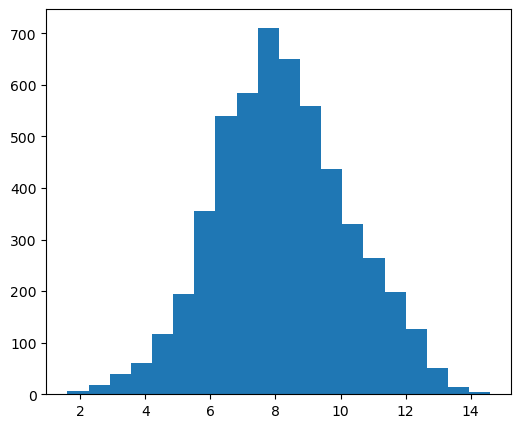

In [21]:
# distribution of non-binary values
plt.figure(figsize=(6,5))
#plt.hist(np.log(normalized_df['nb_votes']), bins=20)
plt.hist((normalized_df['nb_votes']), bins=20)


In [22]:
# normalizations min-max
normalized_df['runtime'] = (normalized_df['runtime'] - normalized_df['runtime'].min()) / (normalized_df['runtime'].max() - normalized_df['runtime'].min())
normalized_df['movie_release'] = (normalized_df['movie_release'] - normalized_df['movie_release'].min()) / (normalized_df['movie_release'].max() - normalized_df['movie_release'].min())
normalized_df['rating'] = (normalized_df['rating'] - normalized_df['rating'].min()) / (normalized_df['rating'].max() - normalized_df['rating'].min())
normalized_df['nb_votes'] = (normalized_df['nb_votes'] - normalized_df['nb_votes'].min()) / (normalized_df['nb_votes'].max() - normalized_df['nb_votes'].min())

In [23]:
# dataframe with only 'runtime', 'movie_release', 'rating', 'nb_votes'
normalized_df_simple = normalized_df.copy()
normalized_df_simple = normalized_df.dropna(subset=['runtime'])
#print('nan in simple',  normalized_df_simple['runtime'].isna().sum()) # 0 ok

normalized_df_simple = normalized_df_simple[['runtime', 'movie_release', 'rating', 'nb_votes']]
print('shape df simple :', np.shape(normalized_df_simple))


# dataframe with questions only
normalized_df_questions = normalized_df.dropna(subset=['q_0', 'q_1', 'q_2', 
                                                       'q_3', 'q_4', 'q_5', 
                                                       'q_6', 'q_7', 'q_8', 
                                                       'q_9', 'q_10', 'q_11', 
                                                       'q_12', 'q_13', 'q_16', 
                                                       'q_17', 'q_18', 
                                                       'q_19']).copy()
normalized_df_questions_only = normalized_df_questions[['q_0', 'q_1', 'q_2', 
                                                       'q_3', 'q_4', 'q_5', 
                                                       'q_6', 'q_7', 'q_8', 
                                                       'q_9', 'q_10', 'q_11', 
                                                       'q_12', 'q_13', 'q_16', 
                                                       'q_17', 'q_18', 
                                                       'q_19', 'rating']].copy()
#print('nan in questions only',  normalized_df_questions_only.isna().sum()) # 0 ok
print('shape df questions only :', np.shape(normalized_df_questions_only))

normalized_df_without_questions = normalized_df.dropna(subset=['runtime']).copy()
normalized_df_without_questions = normalized_df_without_questions.drop(['q_0', 'q_1', 'q_2',
                                                                        'q_3', 'q_4', 'q_5', 
                                                                        'q_6', 'q_7', 'q_8', 
                                                                        'q_9', 'q_10', 'q_11', 
                                                                        'q_12', 'q_13', 'q_16', 
                                                                        'q_17', 'q_18', 
                                                                        'q_19'], axis=1)
#print('nan in without questions',  normalized_df_without_questions.isna().sum()) # 0 ok
print('shape df without quesitions :', np.shape(normalized_df_without_questions))

normalized_df_all = normalized_df_questions.dropna(subset=['runtime']).copy()
#print('nan in all',  normalized_df_all.isna().sum()) # 0 ok
print('shape df all :', np.shape(normalized_df_all))



shape df simple : (5060, 4)
shape df questions only : (5009, 19)
shape df without quesitions : (5060, 23)
shape df all : (4821, 41)


In [24]:
# without questions and without genre
X_df_simple = normalized_df_simple.drop(['rating'], axis=1)
y_df_simple = normalized_df_simple['rating']

# questions only
X_df_question_only = normalized_df_questions_only.drop(['rating'], axis=1)
y_df_question_only = normalized_df_questions_only['rating']

# without questions
X_df_without_questions = normalized_df_without_questions.drop(['rating'], axis=1)
y_df_without_questions = normalized_df_without_questions['rating']

# all
X_df_all = normalized_df_all.drop(['rating'], axis=1)
y_df_all = normalized_df_all['rating']


# Naive Regression

In [25]:
regressor = RandomForestRegressor(n_estimators=150, max_depth=20, )



In [26]:
def RandomForestRegressorModel(X, y, regressor, plot=False, feature_importance=False, nb_features=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    regressor.fit(X_train, y_train)
    R2_train = regressor.score(X_train, y_train)
    R2_test = regressor.score(X_test, y_test)
    #print('R2 train :', R2_train)
    #print('R2 test :', R2_test)
    
    y_pred = regressor.predict(X_test)
    #print('MSE:', mean_squared_error(y_test, y_pred))
    #print('Max error:', max_error(y_test, y_pred))

    if plot:
        plt.figure(figsize=(15, 3))
        x_val = np.arange(len(y_test))
        plt.plot(x_val, y_test)
        plt.plot(y_pred)
        plt.show()

    if feature_importance:
        # Get feature importances
        feature_importances = regressor.feature_importances_
        # Sort features by importance (most important first)
        sorted_indices = np.argsort(-feature_importances)
        sorted_features = [X.columns[i] for i in sorted_indices]
                
        if nb_features != 0:
            important_features = sorted_features[:nb_features]
            return R2_train, R2_test, important_features
        
        
    
    return R2_train, R2_test

### Simple

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     509.9
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          1.67e-289
Time:                        10:50:08   Log-Likelihood:                 4038.1
No. Observations:                5060   AIC:                            -8068.
Df Residuals:                    5056   BIC:                            -8042.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5366      0.008     67.487

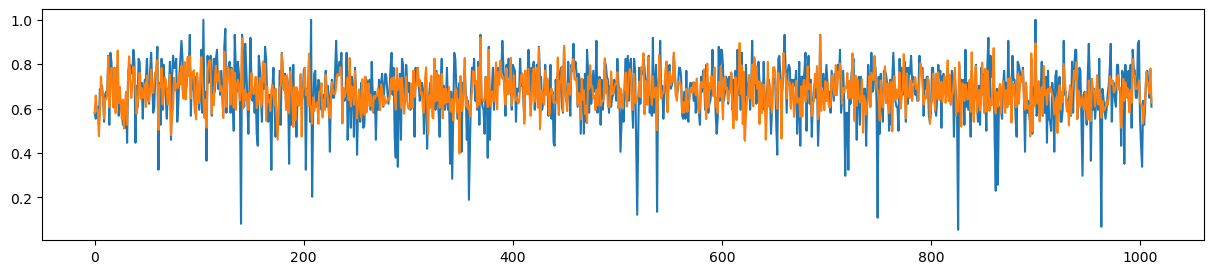

R2 train : 0.8870072419854771
R2 test : 0.25872182560348866
best features : ['nb_votes', 'movie_release', 'runtime']


In [27]:
# simple model 
mod_simple = smf.ols(formula='rating ~ runtime + movie_release + nb_votes', data=normalized_df_simple)
print(mod_simple.fit().summary()) # R² = 0.154

# random forest
R2_train_simple, R2_test_simple, best_features_simple = RandomForestRegressorModel(X_df_simple, y_df_simple, regressor, plot=True, feature_importance=True, nb_features=5) # R² = 0.154

print('R2 train :', R2_train_simple)
print('R2 test :', R2_test_simple)
print('best features :', best_features_simple)

#### Questions only

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     8.075
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           1.35e-21
Time:                        10:50:12   Log-Likelihood:                 3376.6
No. Observations:                5009   AIC:                            -6715.
Df Residuals:                    4990   BIC:                            -6591.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6755      0.004    153.871      0.0

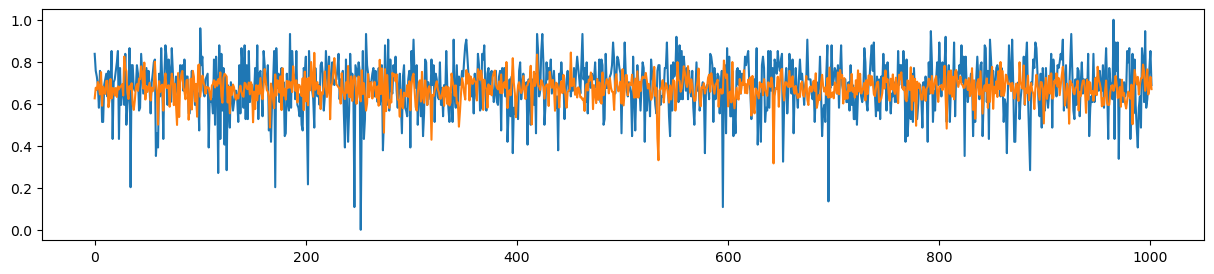

R2 train : 0.6845612321365668
R2 test : -0.1322881283842936
best features : ['q_7', 'q_13', 'q_6', 'q_9', 'q_16']


In [28]:
mod_quest = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 + q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_16 + q_17 + q_18 + q_19', data=normalized_df_questions_only)
print(mod_quest.fit().summary()) # R² = 0.025

# random forest
R2_train_quest, R2_test_quest, best_features_quest = RandomForestRegressorModel(X_df_question_only, y_df_question_only, regressor, plot=True, feature_importance=True, nb_features=5) # R² = 0.025
print('R2 train :', R2_train_quest)
print('R2 test :', R2_test_quest)
print('best features :', best_features_quest)

#### Without questions (with genres)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     102.2
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          4.66e-321
Time:                        10:50:14   Log-Likelihood:                 4033.7
No. Observations:                4821   AIC:                            -8029.
Df Residuals:                    4802   BIC:                            -7906.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6032      0.007     88.153

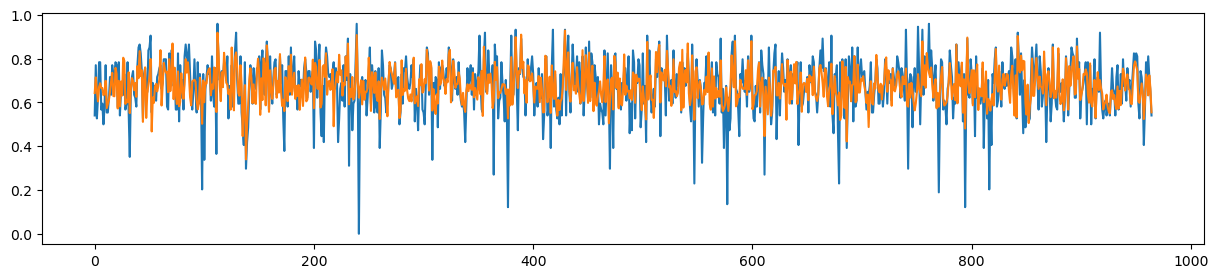

R2 train : 0.9173767380114682
R2 test : 0.4547014928683496
best features : ['nb_votes', 'movie_release', 'runtime', 'Drama', 'World Cinema']


In [29]:
mod_wq = smf.ols(formula='rating ~ movie_release + nb_votes + Action + Adaptation + Adventure + Bollywood + Comedy + Crime + Drama + Erotic + Family + Fantasy + Gay + Indie + LGBT + Musical + Period + Thriller', data=normalized_df_all)
print(mod_wq.fit().summary()) # R² = 0.179

# random forest
R2_train_wq, R2_test_wq, best_features_wq = RandomForestRegressorModel(X_df_all, y_df_all, regressor, plot=True, feature_importance=True, nb_features=5) # R² = 0.179
print('R2 train :', R2_train_wq)
print('R2 test :', R2_test_wq)
print('best features :', best_features_wq)

#### All the dataframe

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     52.32
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          5.44e-312
Time:                        10:50:21   Log-Likelihood:                 4051.8
No. Observations:                4821   AIC:                            -8030.
Df Residuals:                    4784   BIC:                            -7790.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6116      0.008     79.627

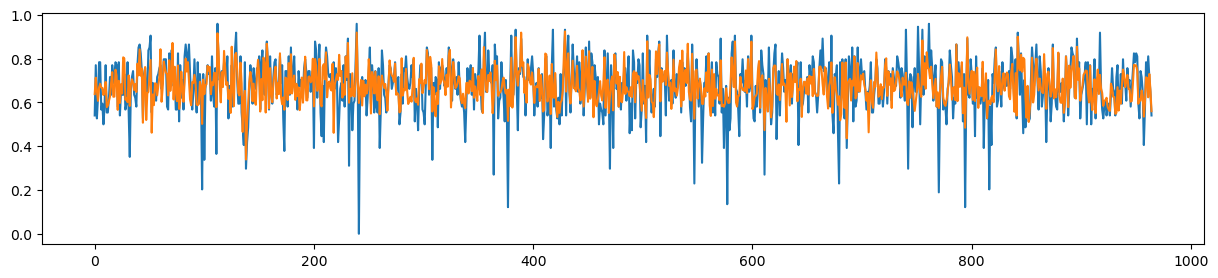

R2 train : 0.9148177171528793
R2 test : 0.4470974389239938
best features : ['nb_votes', 'movie_release', 'runtime', 'Drama', 'World Cinema']


In [30]:
mod_all = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 + q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_16 + q_17 + q_18 + q_19 + movie_release + nb_votes + Action + Adaptation + Adventure + Bollywood + Comedy + Crime + Drama + Erotic + Family + Fantasy + Gay + Indie + LGBT + Musical + Period + Thriller', data=normalized_df_all)
print(mod_all.fit().summary()) # R² = 0.191

# random forest
R2_train_all, R2_test_all, best_features_all = RandomForestRegressorModel(X_df_all, y_df_all, regressor, plot=True, feature_importance=True, nb_features=5) 
print('R2 train :', R2_train_all)
print('R2 test :', R2_test_all)
print('best features :', best_features_all)

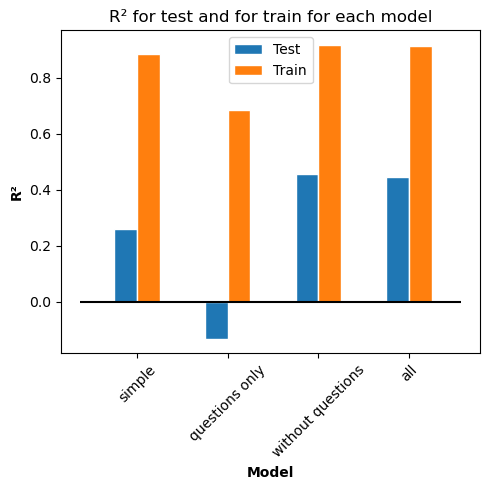

In [31]:
# summary of all models 

R_train = [R2_train_simple, R2_train_quest, R2_train_wq, R2_train_all]
R_test = [R2_test_simple, R2_test_quest, R2_test_wq, R2_test_all]
R_title = ['simple', 'questions only', 'without questions', 'all']

plt.figure(figsize=(5,5))
# set width of bars
barWidth = 0.25

x1 = np.arange(len(R_title))
x2 = [x + barWidth for x in x1]

plt.bar(x1, R_test, width=barWidth, edgecolor='white', label='Test')
plt.bar(x2, R_train, width=barWidth, edgecolor='white', label='Train')
plt.hlines(0, -0.5, 3.7, colors='black')
plt.title('R² for test and for train for each model')
plt.xlabel('Model', fontweight='bold')
plt.ylabel('R²', fontweight='bold')
plt.xticks([r + 0.5 *barWidth for r in range(len(R_title))], R_title)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


Graphical representation of non one-hot variable and ratings

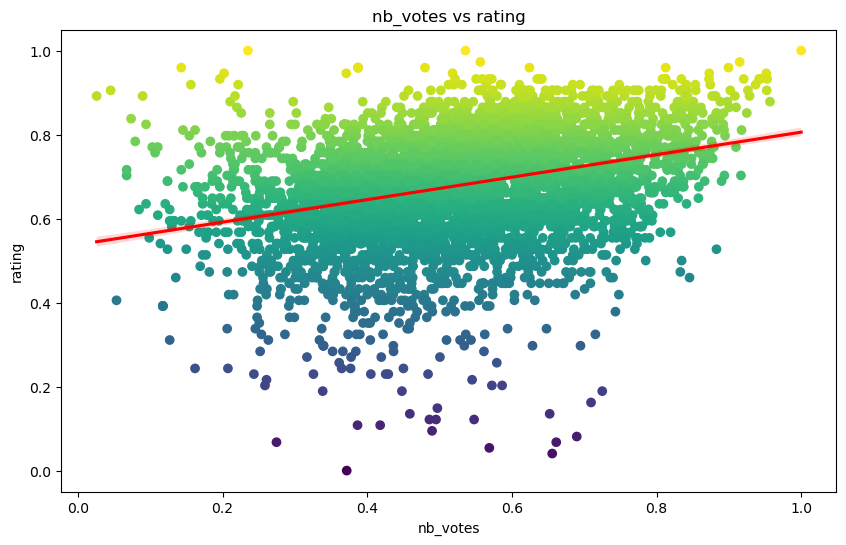

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(normalized_df_simple['nb_votes'], normalized_df_simple['rating'], c=y_df_simple, )
sns.regplot(x='nb_votes', y='rating', data=normalized_df_simple, scatter=False, color='red')
plt.xlabel('nb_votes')
plt.ylabel('rating')
plt.title('nb_votes vs rating')
plt.show()

# red is the regression line
# purple is the lineplot
# the scatter plot is the movies

Le nombre de vote augmente le ratings

Attention : les personnes sont surement influencées par les votes précédents (ou la note globale)

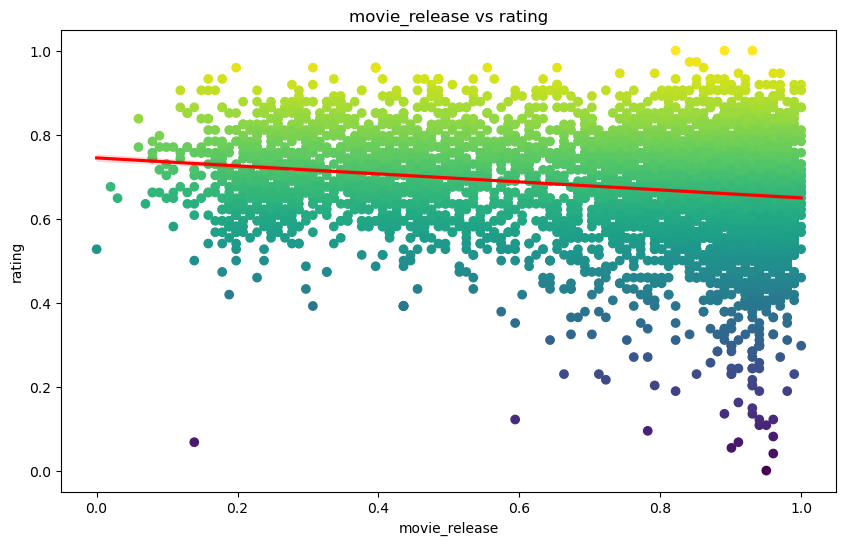

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(normalized_df_simple['movie_release'], normalized_df_simple['rating'], c=y_df_simple, )
sns.regplot(x='movie_release', y='rating', data=normalized_df_simple, scatter=False, color='red')
#sns.lineplot(x='movie_release', y='rating', data=normalized_df_simple, color='purple')
plt.xlabel('movie_release')
plt.ylabel('rating')
plt.title('movie_release vs rating')
plt.show()

# red is the regression line
# purple is the lineplot
# the scatter plot is the movies


Probable bias : on ne va pas regarder des vieux films qui ne sont pas bien

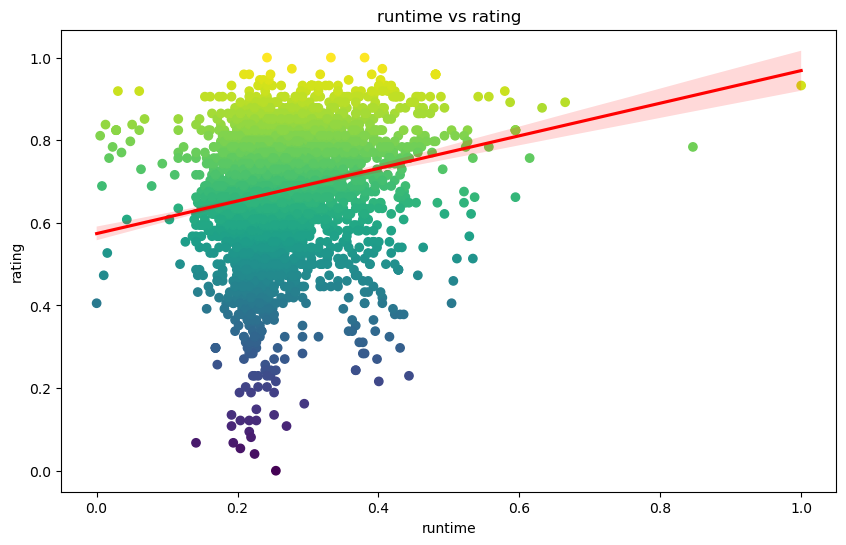

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(normalized_df_simple['runtime'], normalized_df_simple['rating'], c=y_df_simple, )
sns.regplot(x='runtime', y='rating', data=normalized_df_simple, scatter=False, color='red')
#sns.lineplot(x='runtime', y='rating', data=normalized_df_simple, color='purple')
plt.xlabel('runtime')
plt.ylabel('rating')
plt.title('runtime vs rating')
plt.show()

# red is the regression line
# purple is the lineplot
# the scatter plot is the movies


In [35]:
n_features_all = [3,5,7,10,12,15,18,20,30,40,41]
n_features_questions = [3,5,7,10,12,15,18]
n_features_wq = [3,5,7,10,12,15,18,20,22]

In [36]:
def best_feature_randomforest(X, y, regressor, features):
    R2_train = []
    R2_test = []
    best_features = []
    
    for i in features:
        _, _, best_features_i = RandomForestRegressorModel(X, y, regressor, plot=False, feature_importance=True, nb_features=i) 

        best_features.append(best_features_i)
        X_selected = X[best_features_i]
        R2_train_i, R2_test_i = RandomForestRegressorModel(X_selected, y, regressor, plot=False, feature_importance=False, nb_features=0)
        R2_train.append(R2_train_i)
        R2_test.append(R2_test_i)
    
        
        

    return R2_train, R2_test, best_features

In [37]:
def plot_selection_features(R2_train, R2_test, best_features, features):

    print('best features :', best_features)
    print('R² train :', R2_train)
    print('R² test :', R2_test)

    #plot R² for train and test for each number of features
    
    plt.figure(figsize=(5,5))
    plt.plot(features, R2_train, label='Train')
    plt.title('R² for train for each number of features')
    plt.xlabel('Number of features', fontweight='bold')
    plt.ylabel('R²', fontweight='bold')
    plt.legend()
    plt.show()

    plt.figure(figsize=(5,5))
    plt.plot(features, R2_test, label='Test')
    plt.title('R² for test for each number of features')
    plt.xlabel('Number of features', fontweight='bold')
    plt.ylabel('R²', fontweight='bold')
    plt.legend()
    plt.show()
    

    # Flatten the list of lists
    all_features = [feature for features in best_features for feature in features]
    # Count the occurrences of each 'q'
    q_counts = Counter(all_features)
    normalized_counts = [count / len(best_features) for count in q_counts.values()]

    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(q_counts.keys(), normalized_counts)
    plt.xlabel('features')
    plt.ylabel('Frequency of features occurence')
    plt.title('Frequency of Occurrences of selected features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [38]:
print('best features simple :', best_features_simple)
print('best features questions only :', best_features_quest)
print('best features without questions :', best_features_wq)
print('best features all :', best_features_all)

best features simple : ['nb_votes', 'movie_release', 'runtime']
best features questions only : ['q_7', 'q_13', 'q_6', 'q_9', 'q_16']
best features without questions : ['nb_votes', 'movie_release', 'runtime', 'Drama', 'World Cinema']
best features all : ['nb_votes', 'movie_release', 'runtime', 'Drama', 'World Cinema']


In [39]:
def best_feature_RFE(X, y, regressor, features):
    R2_train = []
    R2_test = []
    best_features = []
    
    for i in features:
        rfe = RFE(regressor, n_features_to_select=i)
        rfe.fit(X, y)
        best_features_i = X.columns[rfe.support_].tolist()
        best_features.append(best_features_i)

        X_selected = X[best_features_i]
        R2_train_i, R2_test_i = RandomForestRegressorModel(X_selected, y, regressor, plot=False, feature_importance=False, nb_features=0)
        R2_train.append(R2_train_i)
        R2_test.append(R2_test_i)
    
    return R2_train, R2_test, best_features

best features : [['q_1', 'q_9', 'q_17'], ['q_1', 'q_9', 'q_12', 'q_16', 'q_17'], ['q_1', 'q_8', 'q_9', 'q_12', 'q_13', 'q_16', 'q_17'], ['q_1', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_12', 'q_13', 'q_16', 'q_17'], ['q_1', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_16', 'q_17'], ['q_1', 'q_2', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_16', 'q_17', 'q_18', 'q_19'], ['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_16', 'q_17', 'q_18', 'q_19']]
R² train : [0.0011955996795383061, 0.005645302899600968, 0.028633025101163834, 0.14806898180599748, 0.2683852850980394, 0.5192378973068887, 0.6840133275772722]
R² test : [-0.0054349805708324705, -0.0075208542080678065, -0.03854563499726038, -0.11197955176497487, -0.1541000610144534, -0.2271042292649692, -0.13752229482910105]


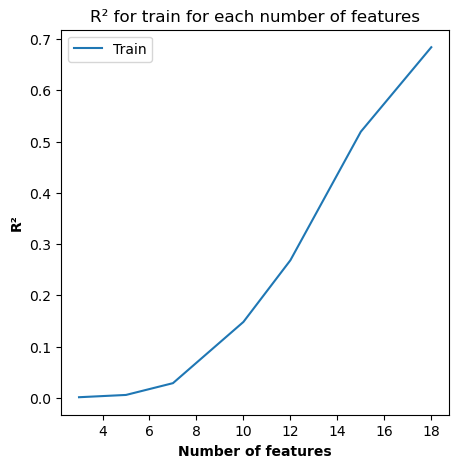

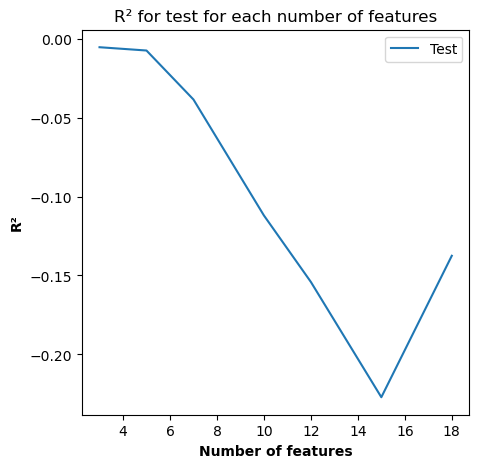

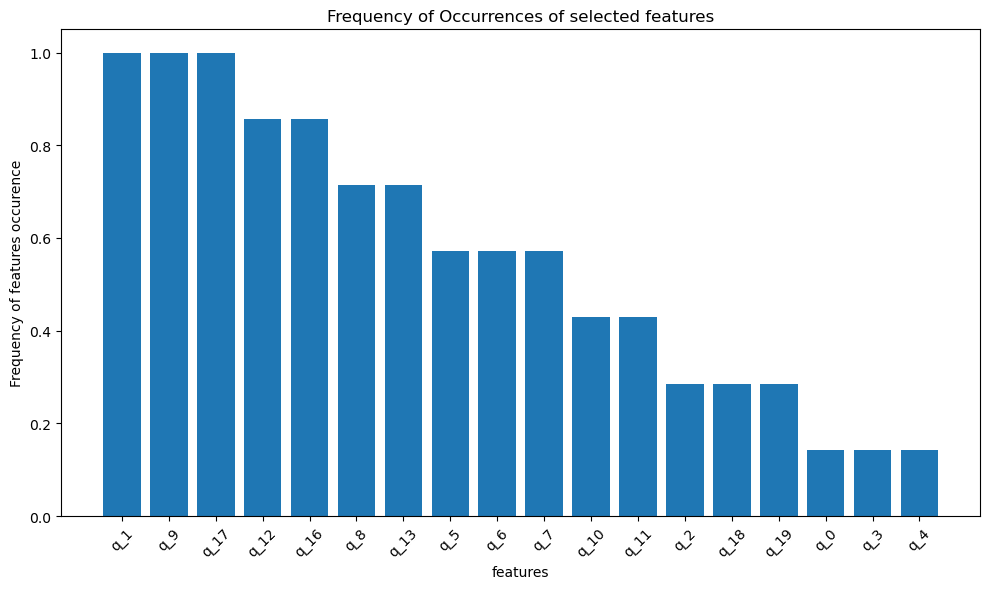

best features : [['q_7', 'q_13', 'q_6'], ['q_7', 'q_6', 'q_13', 'q_16', 'q_10'], ['q_7', 'q_13', 'q_6', 'q_18', 'q_16', 'q_9', 'q_10'], ['q_7', 'q_6', 'q_13', 'q_16', 'q_10', 'q_9', 'q_18', 'q_17', 'q_1', 'q_5'], ['q_7', 'q_6', 'q_13', 'q_16', 'q_9', 'q_10', 'q_18', 'q_17', 'q_5', 'q_19', 'q_1', 'q_2'], ['q_7', 'q_6', 'q_13', 'q_18', 'q_9', 'q_16', 'q_10', 'q_17', 'q_5', 'q_19', 'q_1', 'q_2', 'q_12', 'q_8', 'q_11'], ['q_7', 'q_6', 'q_13', 'q_9', 'q_16', 'q_18', 'q_10', 'q_17', 'q_19', 'q_1', 'q_12', 'q_5', 'q_2', 'q_8', 'q_11', 'q_4', 'q_3', 'q_0']]
R² train : [0.0020604831018508074, 0.012075477647655153, 0.035043111684344375, 0.17154066453153216, 0.34044668710010084, 0.5194476867232034, 0.6823852354374107]
R² test : [0.00024387206503317937, -0.006126231090187062, -0.023650753155977533, -0.1279620978280227, -0.1935672739774834, -0.22778600291972428, -0.13443531504500017]


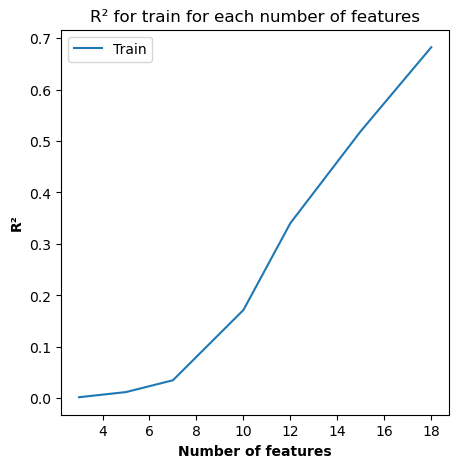

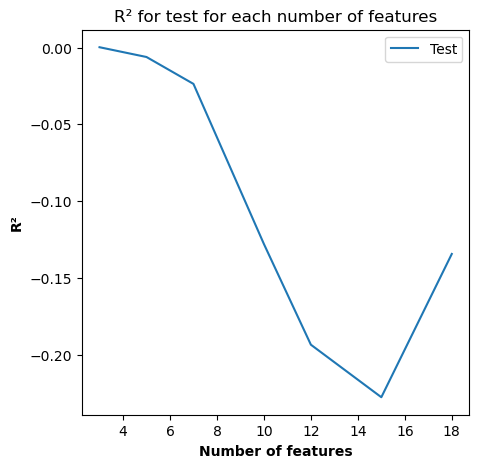

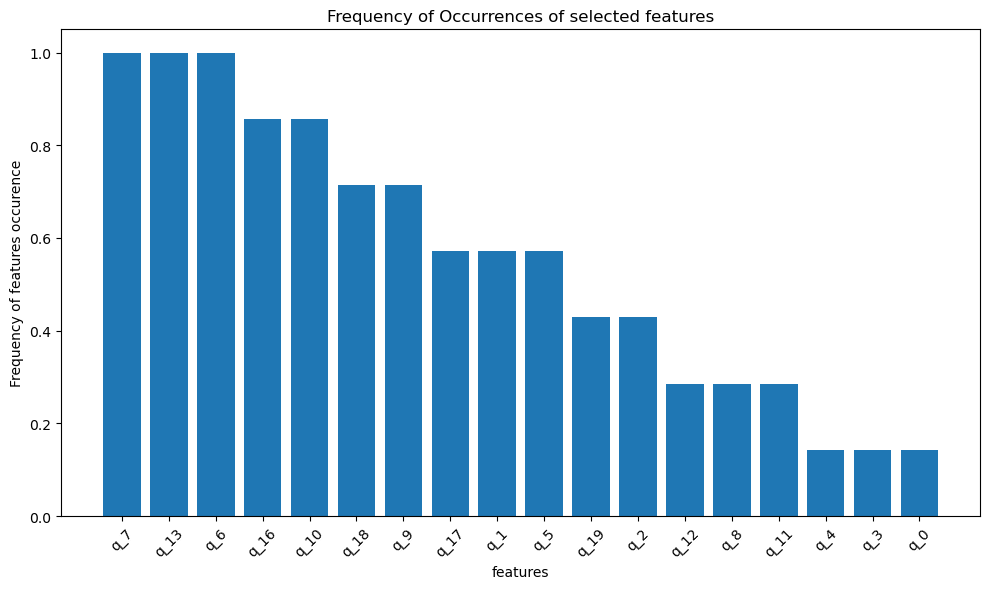

In [41]:
R2_train_questions_rfe, R2_test_questions_rfe, best_features_questions_rfe = best_feature_RFE(X_df_question_only, y_df_question_only, regressor, n_features_questions) 
plot_selection_features(R2_train_questions_rfe, R2_test_questions_rfe, best_features_questions_rfe, n_features_questions)

R2_train_questions_RF, R2_test_questions_RF, best_features_questions_RF = best_feature_randomforest(X_df_question_only, y_df_question_only, regressor, n_features_questions)
plot_selection_features(R2_train_questions_RF, R2_test_questions_RF, best_features_questions_RF, n_features_questions)


best features : [['runtime', 'movie_release', 'nb_votes'], ['runtime', 'movie_release', 'nb_votes', 'Drama', 'World Cinema'], ['runtime', 'movie_release', 'nb_votes', 'Comedy', 'Drama', 'Musical', 'World Cinema'], ['runtime', 'movie_release', 'nb_votes', 'Adventure', 'Comedy', 'Drama', 'Indie', 'Musical', 'Thriller', 'World Cinema'], ['runtime', 'movie_release', 'nb_votes', 'Adventure', 'Comedy', 'Drama', 'Erotic', 'Indie', 'LGBT', 'Musical', 'Thriller', 'World Cinema'], ['runtime', 'movie_release', 'nb_votes', 'Action', 'Adventure', 'Comedy', 'Drama', 'Erotic', 'Family', 'Fantasy', 'Indie', 'LGBT', 'Musical', 'Thriller', 'World Cinema'], ['runtime', 'movie_release', 'nb_votes', 'Action', 'Adventure', 'Bollywood', 'Comedy', 'Crime', 'Drama', 'Erotic', 'Family', 'Fantasy', 'Indie', 'LGBT', 'Musical', 'Period', 'Thriller', 'World Cinema'], ['runtime', 'movie_release', 'nb_votes', 'Action', 'Adaptation', 'Adventure', 'Bollywood', 'Comedy', 'Crime', 'Drama', 'Erotic', 'Family', 'Fantasy', 

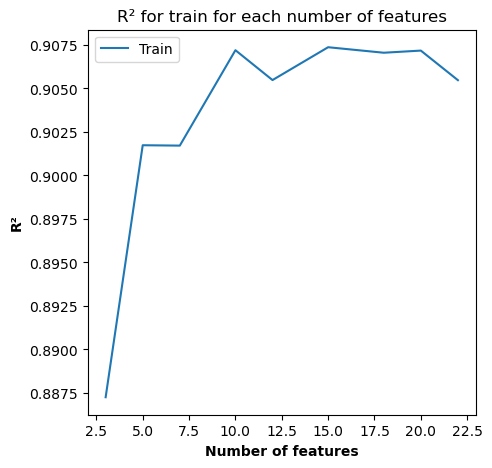

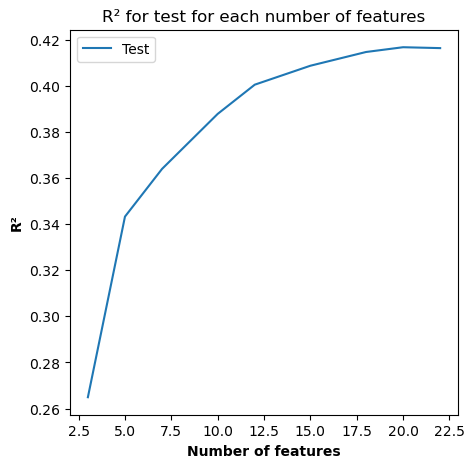

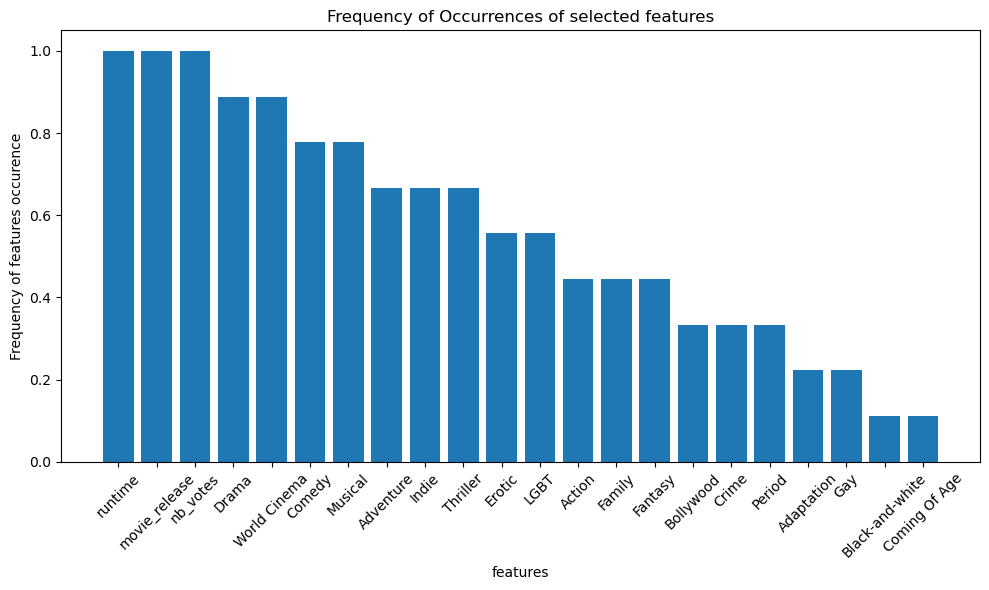

best features : [['nb_votes', 'movie_release', 'runtime'], ['nb_votes', 'movie_release', 'runtime', 'World Cinema', 'Drama'], ['nb_votes', 'movie_release', 'runtime', 'World Cinema', 'Drama', 'Comedy', 'Musical'], ['nb_votes', 'movie_release', 'runtime', 'World Cinema', 'Drama', 'Comedy', 'Musical', 'Indie', 'Fantasy', 'Adventure'], ['nb_votes', 'movie_release', 'runtime', 'World Cinema', 'Drama', 'Comedy', 'Musical', 'Indie', 'Fantasy', 'Adventure', 'Erotic', 'Thriller'], ['nb_votes', 'movie_release', 'runtime', 'World Cinema', 'Drama', 'Comedy', 'Musical', 'Indie', 'Fantasy', 'Adventure', 'Erotic', 'Thriller', 'Family', 'Action', 'LGBT'], ['nb_votes', 'movie_release', 'runtime', 'World Cinema', 'Drama', 'Comedy', 'Musical', 'Indie', 'Fantasy', 'Adventure', 'Erotic', 'Thriller', 'Family', 'Action', 'LGBT', 'Period', 'Crime', 'Bollywood'], ['nb_votes', 'movie_release', 'runtime', 'World Cinema', 'Drama', 'Comedy', 'Musical', 'Indie', 'Fantasy', 'Adventure', 'Erotic', 'Thriller', 'Famil

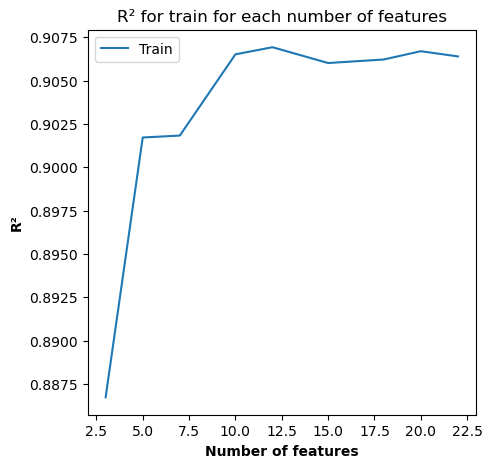

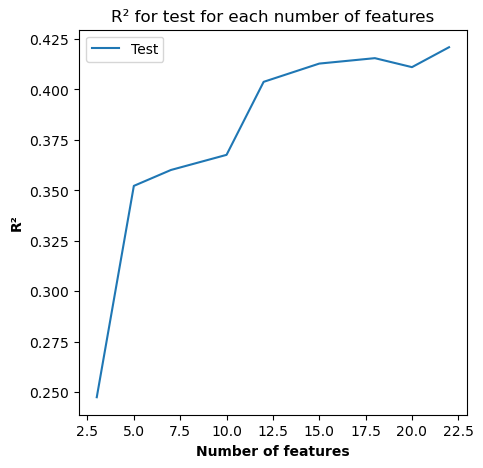

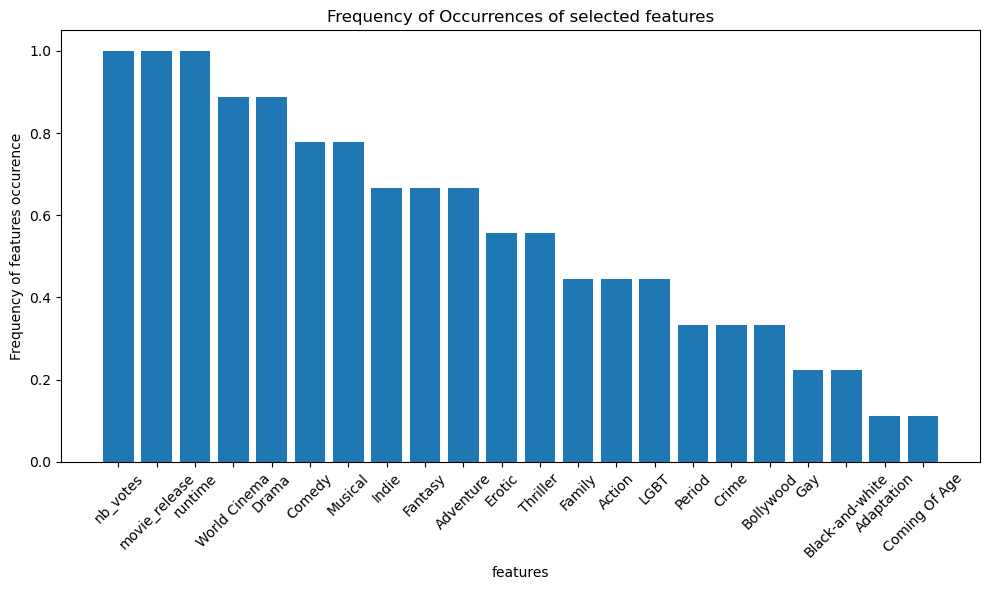

In [42]:
R2_train_wq_rfe, R2_test_wq_rfe, best_features_wq_rfe = best_feature_RFE(X_df_without_questions, y_df_without_questions, regressor, n_features_wq)
plot_selection_features(R2_train_wq_rfe, R2_test_wq_rfe, best_features_wq_rfe, n_features_wq)

R2_train_wq_RF, R2_test_wq_RF, best_features_wq_RF = best_feature_randomforest(X_df_without_questions, y_df_without_questions, regressor, n_features_wq)
plot_selection_features(R2_train_wq_RF, R2_test_wq_RF, best_features_wq_RF, n_features_wq)

In [43]:
R2_train_all_rfe, R2_test_all_rfe, best_features_all_rfe = best_feature_RFE(X_df_all, y_df_all, regressor, n_features_all)
plot_selection_features(R2_train_all_rfe, R2_test_all_rfe, best_features_all_rfe, n_features_all)

R2_train_all_RF, R2_test_all_RF, best_features_all_RF = best_feature_randomforest(X_df_all, y_df_all, regressor, n_features_all)
plot_selection_features(R2_train_all_RF, R2_test_all_RF, best_features_all_RF, n_features_all)